In [1]:
from tifffile import imread
import os
from matplotlib import pyplot as plt
import json
from scipy.io import loadmat
import h5py
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, csgraph
from scipy.io import savemat

from write_features_functions import *
from util import *

File structure:
seg_path (has both ndip and geojson files)
-ndpi files
-geojson files

json_path
-json file output from stardist

In [2]:
# liver erythropoetic cells

# path to StarDist json output
json_path = r'/home/donald/Desktop/Andre_expansion/data/monkey_fetus/Stardist/StarDist_12_25_23/json'

# path to WSI and .geojson with the selected nuclei
seg_path = r'/home/donald/Desktop/Andre_expansion/data/monkey_fetus/Stardist/StarDist_12_25_23/get_cellular_data_from_masks/liver_erythropoetic'

In [3]:
# make full path lists (just run with input above)
geojson_pth_list = [os.path.join(seg_path,f) for f in os.listdir(seg_path) if f.endswith(".geojson")]

ndpi_pth_list = []
json_pth_list = []

for f in geojson_pth_list:
    nm = os.path.basename(f)[:-8] # get rid of .geojson from name
    json_f_pth = os.path.join(json_path,"".join([nm,'.json'])) # add .json
    json_pth_list.append(json_f_pth)
    ndpi_f_pth = os.path.join(seg_path,"".join([nm,'.ndpi'])) # add .ndpi
    ndpi_pth_list.append(ndpi_f_pth)

Match selected nuclei from geojson file and stardist output below and visualize

[2982, 23899, 512]


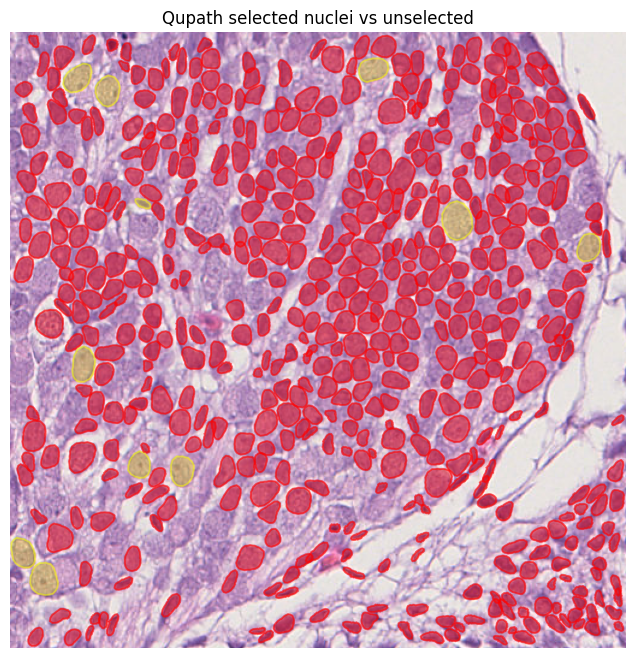

In [5]:
# cropping stuff is only used for visualization (you can change to show what you want or skip)

# these numbers are specific to the slide I annotated during testing
um_adjust = 1/0.4416 # resolution
cropping = [11320,6440] # x and y in um
cropping = [int(i*um_adjust) for i in cropping]
cropping = cropping[::-1]

cropping.append(512) # tile size
print(cropping)

for i in range(len(geojson_pth_list)):
    ndpi_pth_f = ndpi_pth_list[i]
    geojson_file_f = geojson_pth_list[i]
    json_file_f = json_pth_list[i]

    centroids_ann = get_geojson_centroids(geojson_file_f)
    centroids_json, contours_json = get_json_centroids(json_file_f)

    matching = colocalize_points(centroids_ann, centroids_json, r=20)
    plot_results(ndpi_pth_f, cropping, centroids_json, contours_json, matching)
    break

Save a json file with only 

In [6]:
for i in range(len(geojson_pth_list)):
    ndpi_pth_f = ndpi_pth_list[i]
    geojson_file_f = geojson_pth_list[i]
    json_file_f = json_pth_list[i]

    # get centroids and contours from stardist output and centroids of selected nuclei
    centroids_ann = get_geojson_centroids(geojson_file_f)
    centroids_json, contours_json = get_json_centroids(json_file_f)

    # match centroids from selected nuclei with stardist output
    matching = colocalize_points(centroids_ann, centroids_json, r=20)
    indices_matched = get_matched_inds(ndpi_pth_f, centroids_json, contours_json, matching)
    centroids_annotated = centroids_json[indices_matched]
    contours_annotated = contours_json[indices_matched]

    # prepare to save
    nm = os.path.basename(geojson_file_f[:-3])
    out_centroids = centroids_annotated.tolist() # json module doesn't like np arrays so need to convert to python list
    out_contours = contours_annotated.tolist()

    # save json file
    save_json_data_from_selected(out_contours, out_centroids, seg_path, nm)

Finished monkey_fetus_40_0362.json
Finished monkey_fetus_40_0633.json


Extract morphology/color features from the nuclei in that json file

In [7]:
# make outpath for pickle dfs
out_pth_pkl = os.path.join(seg_path,'features_pkl')
if not os.path.exists(out_pth_pkl):
    os.mkdir(out_pth_pkl)

for geo_json_f_nm in geojson_pth_list:
    nm = os.path.basename(geo_json_f_nm[:-8])

    json_file = os.path.join(seg_path,"".join([nm,".json"]))
    WSI_file = os.path.join(seg_path,"".join([nm,".ndpi"]))

    write_df_features_pkl_single(json_file, WSI_file, out_pth_pkl)

/home/donald/Desktop/Andre_expansion/data/monkey_fetus/Stardist/StarDist_12_25_23/get_cellular_data_from_masks/spinal_ganglia/features_pkl/monkey_fetus_40_0362.pkl
/home/donald/Desktop/Andre_expansion/data/monkey_fetus/Stardist/StarDist_12_25_23/get_cellular_data_from_masks/spinal_ganglia/features_pkl/monkey_fetus_40_0633.pkl


Finally, convert to .mat file to bring into MATLAB

In [8]:
# make mat outpath
mat_pth = os.path.join(out_pth_pkl,'nuclei_features_mats')
if not os.path.exists(mat_pth):
    os.mkdir(mat_pth)

df_full_path_list = [os.path.join(out_pth_pkl,f) for f in os.listdir(out_pth_pkl) if f.endswith(".pkl")]

for dfnm in df_full_path_list:
    
    outnm = os.path.join(mat_pth,"".join([os.path.basename(dfnm)[:-4],'.mat']))
    
    print("Saving: {}".format(dfnm))
        
    with open(os.path.join(dfnm), 'rb') as f:
        df = pd.read_pickle(f)

    col_names = df.columns.tolist()
    df = [_ for _ in df.to_numpy()]
    df = np.array(df)
    
    savemat(outnm, {'features':df, 'feature_names':col_names})

Saving: /home/donald/Desktop/Andre_expansion/data/monkey_fetus/Stardist/StarDist_12_25_23/get_cellular_data_from_masks/spinal_ganglia/features_pkl/monkey_fetus_40_0362.pkl
Saving: /home/donald/Desktop/Andre_expansion/data/monkey_fetus/Stardist/StarDist_12_25_23/get_cellular_data_from_masks/spinal_ganglia/features_pkl/monkey_fetus_40_0633.pkl


In [18]:
# test to make sure pickle df looks right (it does)
pkl_pth = '/home/donald/Desktop/Andre_expansion/data/monkey_fetus/Stardist/StarDist_12_25_23/get_cellular_data_from_masks/liver_erythropoetic/features_pkl/monkey_fetus_40_0353.pkl';
p = pd.read_pickle(pkl_pth)
p.head()

,Centroid_x,Centroid_y,Area,Perimeter,Circularity,Aspect Ratio,compactness,eccentricity,extent,form_factor,...,minor_axis_length,major_axis_length,orientation_degrees,r_mean_intensity,g_mean_intensity,b_mean_intensity,r_std,g_std,b_std,slide_num
0,26314.0,14108.0,251.111786,57.425545,0.956900,1.119134,13.132371,0.448967,0.772840,1.045041,...,17.039148,19.069086,5416.352539,167.960007,111.389999,167.509995,44.828964,29.874203,44.485268,353.0
1,26270.0,13970.0,334.436890,66.200180,0.958972,1.047414,13.104007,0.297467,0.775412,1.042784,...,20.292316,21.254463,3594.843262,166.009995,109.330002,166.490005,51.527248,34.162773,51.434105,353.0
2,26218.0,13976.0,311.578186,63.882225,0.959438,1.179060,13.097640,0.529782,0.776650,1.042277,...,18.446030,21.748966,3441.183838,170.059998,110.430000,167.139999,50.911697,33.141613,49.852448,353.0
3,26586.0,14046.0,261.488220,58.293633,0.966985,1.103042,12.995413,0.422026,0.777241,1.034142,...,17.464338,19.263899,2521.784424,173.509995,115.279999,170.889999,47.512421,31.577032,46.568947,353.0
4,26546.0,14096.0,295.359344,62.822308,0.940444,1.337823,13.362171,0.664281,0.774094,1.063328,...,16.888033,22.593204,5042.456543,174.110001,116.559998,171.250000,50.942112,34.690319,49.550377,353.0
